## 1) Extraction et exploration des données

In [26]:
import pandas as pd

# Chargement des datasets
journeys = pd.read_csv('journeys.csv')
stations = pd.read_csv('stations.csv')

# Inspection de stations.csv
print("\nForme de stations :", stations.shape)
print("Nombre unique d'ID de stations :", stations['Station ID'].nunique())
print("Colonnes de stations :", stations.columns.tolist())
print("Aperçu des 5 premières lignes :\n", stations.head())


Forme de stations : (773, 5)
Nombre unique d'ID de stations : 773
Colonnes de stations : ['Station ID', 'Capacity', 'Latitude', 'Longitude', 'Station Name']
Aperçu des 5 premières lignes :
    Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square  


Au total, notre jeu de données contient 773 lignes (soit 773 stations de vélos) et 5 colonnes.

In [27]:
print("Valeurs manquantes :\n", stations.isnull().sum())

Valeurs manquantes :
 Station ID      0
Capacity        0
Latitude        0
Longitude       0
Station Name    0
dtype: int64


Aucune valeur manquante dans le dataset !!

In [28]:
# Inspection de journeys.csv
print("Forme de journeys :", journeys.shape)  # Nombre de lignes et colonnes
print("Colonnes de journeys :", journeys.columns.tolist())

Forme de journeys : (1542844, 14)
Colonnes de journeys : ['Journey Duration', 'Journey ID', 'End Date', 'End Month', 'End Year', 'End Hour', 'End Minute', 'End Station ID', 'Start Date', 'Start Month', 'Start Year', 'Start Hour', 'Start Minute', 'Start Station ID']


Le dataset journeys a 1 542 844 lignes et 14 colonnes, soit 1 542 844 trajets d'une station à une autre. À priori, les colonnes d'intérêt pour nos premières analyses à savoir la constitution de la matrice carrée A d'adjacence (où A[i,j] représentera le nombre de trajets de la station i à joù A[i,j] représentera le nombre de trajets de la station i à j) sont 'Journey ID' (l'identifiant d'un trajet entre deux stations), 'Start Staion ID' et 'End Station ID' (respectivement les stations de départ et d'arrivée du trajet).

In [29]:
print("Aperçu des 5 premières lignes :\n", journeys.head())

Aperçu des 5 premières lignes :
    Journey Duration  Journey ID  End Date  End Month  End Year  End Hour  \
0            2040.0         953        19          9        17        18   
1            1800.0       12581        19          9        17        15   
2            1140.0        1159        15          9        17        17   
3             420.0        2375        14          9        17        12   
4            1200.0       14659        13          9        17        19   

   End Minute  End Station ID  Start Date  Start Month  Start Year  \
0           0             478          19            9          17   
1          21             122          19            9          17   
2           1             639          15            9          17   
3          16             755          14            9          17   
4          33             605          13            9          17   

   Start Hour  Start Minute  Start Station ID  
0          17            26              

In [30]:
cols_to_keep = ['Journey Duration']
print("Statistiques descriptives :\n", journeys[cols_to_keep].describe())

Statistiques descriptives :
        Journey Duration
count      1.542844e+06
mean       1.328576e+03
std        6.718370e+03
min        0.000000e+00
25%        5.100000e+02
50%        8.470000e+02
75%        1.346000e+03
max        1.984700e+06


En moyenne, les trajets entre stations dure 22 minutes, ce qui semble raisonnable pour des trajets urbains en vélo. Cela dit, la forte variabilité entre les durées(écart-type de 112 minutes) met l'accent sur l'existence de quelques trajets particuliers à durées très faibles ou trop élevées (outliers potentiels). Ce que nous confirme les extrêmes de la distribution des durées (min 0 min, max 33 078 min). Une attention particulière sur ces trajets est requise.

Analysons-les étape par étape pour décider si les retirer avant de construire la matrice A indispensable pour nos analyses.


In [31]:
Min = journeys['Journey Duration'].min()
Max = journeys['Journey Duration'].max()

lines = (journeys['Journey Duration'] == Min) | (journeys['Journey Duration'] == Max)
journeys.loc[lines].sort_values(by='Journey Duration', ascending=False)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
1346083,1984700.0,2540,24,8,17,17,25,123,1,8,17,18,6,93
1109644,0.0,5285,8,8,17,8,47,215,8,8,17,8,47,215
1097635,0.0,7744,22,8,17,19,5,676,22,8,17,19,5,676
5827,0.0,8281,16,9,17,14,22,626,16,9,17,14,22,626
1541077,0.0,12366,7,8,17,20,39,763,7,8,17,20,39,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947991,0.0,13904,17,8,17,17,22,228,17,8,17,17,22,228
960153,0.0,7620,18,8,17,0,25,193,18,8,17,0,25,193
993122,0.0,8304,19,8,17,11,3,39,19,8,17,11,3,39
1047602,0.0,1792,21,8,17,9,15,717,21,8,17,9,15,717


Après inspection, le trajet de 1 984 700 secondes soit environ 33 078 minutes semble bien logique puisqu'il a débuté de la station 93 et pris fin à la station 123 et a duré du 01/08/2017 à 18h 06 au 24/08/2017 à 17h 25, soit environ 23 jours. Une idée de la distance entre ces deux stations pourraient davantage conforter notre analyse.

In [32]:
s93 = stations.set_index('Station ID').loc[93]
s123 = stations.set_index('Station ID').loc[123]

print(f"Station de départ : {s93['Station Name']}")
print(f"Station d'arrivée : {s123['Station Name']}")

# Calcul de la distance entre les stations de départ et d'arrivée pour les trajets de 1 984 700 secondes

'''
Pour calculer la distance géographique entre stations 93 et 123 en utilisant les latitudes/longitudes de stations.csv, 
nous utilisons la formule Haversine (distance à vol d'oiseau en km). Elle est basée sur la formule de la sphère terrestre.
'''

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calcul la distance géodésique (à vol d'oiseau) entre deux points
    sur la terre (spécifiés en degrés décimaux)
    """
    # conversion des degrés décimaux en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # formule de haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 # calcul de la distance
    c = 2 * asin(sqrt(a)) # distance en radians
    r = 6371 # rayon de la terre en kilomètres
    return c * r # distance en kilomètres   

distance = haversine(s93['Longitude'], s93['Latitude'], s123['Longitude'], s123['Latitude'])
print(f"Distance entre les stations 93 et 123 : {distance:.2f} km")


Station de départ : Cloudesley Road, Angel
Station d'arrivée : St. John Street, Finsbury
Distance entre les stations 93 et 123 : 0.74 km


La distance à vol d'oiseau entre les stations 93 et 123 est de 0.74 Km. Il n'est donc pas logique qu'un trajet direct à vélo de l'une à l'autre puisse prendre 23 à jours, à moins qu'il ne s'agisse d'un prêt longue durée, d'un non-retour du vélo concerné ou d'une erreur du système. 

Cela dit, puisque nos analyses seront plus ou moins focalisées sur le flux des trajets entre stations (nombre d'occurrences, indépendamment de la durée), la durée des trajets n'est à priori pas une information capitale. Le fait qu'il y ait eu un trajet entre ces deux stations (93 et 123) est le plus important. Nous garderons donc cette ligne dans notre jeu de données pour ne pas sous-estimer les connexions rares mais existantes.

En ce qui concerne les trajets à 00s, on peut constater qu'il s'agit en réalité de trajet non effectué, puisque les informations temporelles (date, jour, heure, minute) et de localisation (station) sont exactement les mêmes. Devrons nous les retirer ? Analysons plus en détail les trajets concernés.

In [33]:
df_test = journeys.loc[journeys['Journey Duration'] == 0].copy()
df_test['test'] = (df_test['Start Station ID'] == df_test['End Station ID']) & (df_test['Start Date'] == df_test['End Date']) & (df_test['Start Hour'] == df_test['End Hour']) & (df_test['Start Minute'] == df_test['End Minute'])
print(f"Nombre de trajets potentiellement non effectués : {len(df_test)}")
print(f"Tous les trajets à 0s sont-ils des trajets non effectués ? {all(df_test['test'])}")
print(f"Nombre de trajets à 0s, mais qui ne sont pas des trajets non effectués : {(~df_test['test']).sum()}")

Nombre de trajets potentiellement non effectués : 1609
Tous les trajets à 0s sont-ils des trajets non effectués ? False
Nombre de trajets à 0s, mais qui ne sont pas des trajets non effectués : 18


Finalement, tous les trajets à 0s de notre dataset ne sont pas des non-trajets, il en existe 18 sur 1609.
Vérifions ce qui cloche avec ces trajets.

In [34]:
# Affichage des trajets à 0s qui ne sont pas des trajets non effectués
df_test[~df_test['test']]

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID,test
131483,0.0,11039,18,9,17,19,43,701,18,9,17,19,43,632,False
138715,0.0,14438,19,9,17,9,19,217,19,9,17,9,19,200,False
175198,0.0,6512,13,9,17,7,48,361,13,9,17,7,48,154,False
228221,0.0,6104,10,9,17,16,0,372,10,9,17,16,0,809,False
252428,0.0,13130,12,9,17,18,47,272,12,9,17,18,47,347,False
255394,0.0,13408,11,9,17,8,22,251,11,9,17,8,22,507,False
329788,0.0,1493,12,9,17,8,8,735,12,9,17,8,8,659,False
336862,0.0,13145,8,9,17,9,2,374,8,9,17,9,2,154,False
362148,0.0,13003,11,9,17,8,25,379,11,9,17,8,25,661,False
430015,0.0,2803,4,9,17,8,24,361,4,9,17,8,24,154,False


On constate qu'à part les données sur les stations de départ et d'arrivée, toutes les autres informations (temporelles) sont exactement les mêmes. On en déduit qu'il s'agit certaienemt d'erreurs du système d'enregistrement des données.

Toujours est-il que la durée n'influence pas directement la matrice A. Elle se base uniquement sur les paires (Start Station ID, End Station ID) et dans ces cas précis nous avons des stations bien distinctes. Nous garderons donc ces lignes également.

Finalement, seuls les non-tajets seront retirés de notre jeu de données, puisqu'ils ne sont pas pertinents. Ces entrées ajouteraient des "self-loops" (A[i,i] +=1), ce qui va biaiser nos analyses sur la connectivité (nous voulons des flux entre stations distinctes). De plus ces entrées constituent moins de 0.5% de notre jeu de données globales.

Quid des trajets avec les mêmes stations de départ et d'arrivée, mais des informations temporelles différentes ?

In [35]:
# Filtre self-loops avec Journey Duration > 0 
self_loops_positive = journeys[(journeys['Start Station ID'] == journeys['End Station ID']) & (journeys['Journey Duration'] > 0)]

# Nombre
count = len(self_loops_positive)
print(f"Nombre de self-loops avec Duration > 0 : {count} ({count / len(journeys) * 100:.2f}% du total)")

# Stats sur durations de ces cas
print("Stats durations :\n", self_loops_positive['Journey Duration'].describe())

Nombre de self-loops avec Duration > 0 : 72552 (4.70% du total)
Stats durations :
 count     72552.000000
mean       3043.823409
std        5639.499641
min           1.000000
25%         851.000000
50%        1710.000000
75%        3628.000000
max      460180.000000
Name: Journey Duration, dtype: float64


Nous avons 4.7% des entrées qui vérifient cette éventualité. Etant donné qu'ils ne contribuent pas à la connectivité inter-stations (liens entre i et j où i != j), qui est clé pour le clustering basé sur les patterns de mobilité globale, nous les retirons de notre jeu de données. De quoi obtenir une matrice A centrée sur les interactions pertinentes, sans diagonale non-zéro. 

In [36]:
# Retrait des self-loops (Start Station ID == End Station ID)
journeys_clean = journeys[journeys['Start Station ID'] != journeys['End Station ID']].copy()

print(f"Nombre de trajets après nettoyage : {len(journeys_clean)} ({len(journeys_clean)/len(journeys)*100:.2f}% conservés)")


Nombre de trajets après nettoyage : 1468701 (95.19% conservés)


Tous les cas non pertinents pour nos analyses representent moins de 5% de notre jeu de données de départ. Même en les retirant, nous conservant donc la majorité de nos données pour une analyse qualitative.

In [37]:
# Inspection de journeys_clean
print("Valeurs manquantes :\n", journeys_clean.isnull().sum())
print("Nombre unique de stations de départ :", journeys_clean['Start Station ID'].nunique())
print("Nombre unique de stations d'arrivée :", journeys_clean['End Station ID'].nunique())

Valeurs manquantes :
 Journey Duration    0
Journey ID          0
End Date            0
End Month           0
End Year            0
End Hour            0
End Minute          0
End Station ID      0
Start Date          0
Start Month         0
Start Year          0
Start Hour          0
Start Minute        0
Start Station ID    0
dtype: int64
Nombre unique de stations de départ : 779
Nombre unique de stations d'arrivée : 779


Nous avons maintenant un jeu de données propre et prêt pour nos analyses. Toujours est-il que contrairement au jeu de données sur les stations qui contenait 773 stations uniques, celui sur les trajets en contient 779.

Pour la matrice A carrée, nous devons inclure toutes les stations uniques de l'union des deux datasets (779 au total) pour une représentation complète. Nous éviterons ainsi de perdre des flux impliquant ces 6 stations supplémentaires. Pour les visualisations géographiques ultérieures (e.g., graphe avec lat/long), elles auront des coordonnées manquantes. Nous les exclueront donc des plots. D'ailleurs, si ces 6 sations ont peu de trajets, leur impact sur notre matrice Z issue de A et le clustering sera minime.

## 2) Construction de la matrice A de connectivité

In [38]:
import numpy as np

# Stations uniques dans stations.csv
stations_ids = set(stations['Station ID'].unique())

# Stations uniques dans journeys_clean (union Start et End)
journeys_starts = set(journeys_clean['Start Station ID'].unique())
journeys_ends = set(journeys_clean['End Station ID'].unique())
journeys_ids = journeys_starts.union(journeys_ends)

# Union totale pour A carrée
all_station_ids = sorted(stations_ids.union(journeys_ids))
n_stations = len(all_station_ids)
print(f"Nombre total de stations uniques (union) : {n_stations}") 

# Mapping ID -> index
id_to_index = {sid: idx for idx, sid in enumerate(all_station_ids)}

# Nombre de trajets
counts = journeys_clean.groupby(['Start Station ID', 'End Station ID']).size().reset_index(name='n_trips')

# Matrice A dirigée carrée
A = pd.pivot_table(counts, values='n_trips', index='Start Station ID', columns='End Station ID', fill_value=0)
A = A.reindex(index=all_station_ids, columns=all_station_ids, fill_value=0)
A_np = A.to_numpy()

# Version symétrique pour clustering
A_sym = (A_np + A_np.T) / 2

# Sauvegarde A
np.save('A_sym.npy', A_sym)
print(f"Taille de A : {A.shape}")

Nombre total de stations uniques (union) : 781
Taille de A : (781, 781)


In [39]:
# Sparsité
sparsity = 1 - np.count_nonzero(A_np) / A_np.size
print(f"Sparsité de A : {sparsity:.2%}")  # % de zéros  

# Stats des counts non-zéros
non_zero = A_np[A_np > 0].flatten()
non_zero_series = pd.Series(non_zero)
print("Statistiques des counts non-zéros :\n", non_zero_series.describe())

mean = non_zero.mean()
var = non_zero.var()
print(f"Moyenne : {mean:.2f}, Variance : {var:.2f}")

Sparsité de A : 63.26%
Statistiques des counts non-zéros :
 count    224070.000000
mean          6.554653
std          13.251891
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         990.000000
dtype: float64
Moyenne : 6.55, Variance : 175.61


## 3) Déduction de Z à partir de A

La matrice A est une grille carrée (781 x 781) où chaque entrée A[i,j] est un nombre entier positif (count) : le nombre de trajets de la station i à j. Ces counts ne sont pas parfaits, ils varient beaucoup en raison de facteurs aléatoires à savoir la météo, les heures de pointe, les événements dans la ville, etc. Pour déduire Z de manière probabiliste, nous assumons que chaque A[i,j] suit une distribution de probabilité qui modélise ce bruit naturel.

C'est-à-dire qu'au lieu de traiter A comme fixe, on fait l'hypothèse que chaque A[i,j] est tiré d'une loi probabiliste avec des paramètres dépendant de Z (e.g., $p(A_{ij} \mid Z) = \dots$). Cette approche nous permettra de gérer l'incertitude, d'estimer Z avec plus de robustesse, et de calculer des vraissemblances pour le clustering GMM sur Z.

Pour l'hypothèse sur la distribution, nous ferons le choix entre deux distributions. La distribution Poisson et la Negative Binomiale. 

Poisson : Le taux attendu de trajets de i à j dépend des similarités latentes en Z. $$ A_{ij} \sim \text{Poisson}(\lambda_{ij}), \quad \lambda_{ij} = \exp(Z_i \cdot Z_j) $$ (produit scalaire des vecteurs latents de i et j, pour que λ >0).

Negative Binomiale : $$ A_{ij} \sim \text{NegativeBinomial}(\mu_{ij}, \theta), \qquad \mu_{ij} = \exp(Z_i \cdot Z_j)$$


Notre choix dépendra des statistiques sur les A[i,j], puisque pour la loi poisson moy = var = lambda et pour la négative binomial var = μ + (μ² / θ) (Si θ grand, var ≈ μ (comme Poisson) ; si θ petit, var >> μ (overdispersion)).

Overdispersion détectée : On supposera la Negative Binomial pour modéliser A_ij (variabilité due à pics d'usage).


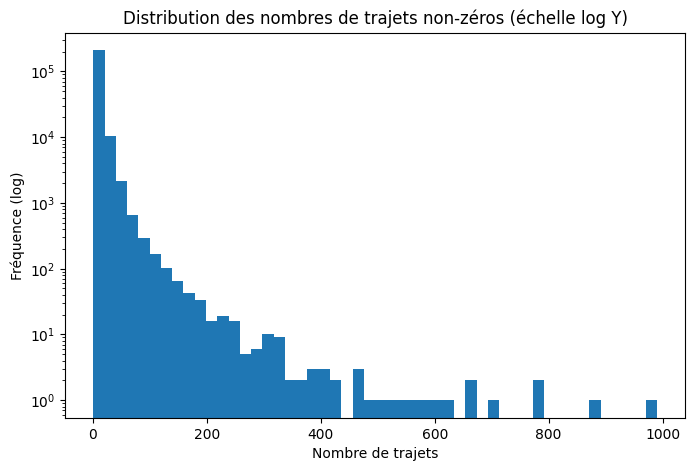

In [40]:
# Interprétation simple
if var > mean * 1.5:  # Seuil approximatif pour overdispersion
    print("Overdispersion détectée : On supposera la Negative Binomial pour modéliser A_ij (variabilité due à pics d'usage).")
elif abs(var - mean) < mean * 0.1:
    print("Distribution Poisson-like : On optera pour une Poisson pour A_ij (counts indépendants).")
else:
    print("Possible mix.")

# Histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(non_zero, bins=50, log=True)
plt.title('Distribution des nombres de trajets non-zéros (échelle log Y)')
plt.xlabel('Nombre de trajets')
plt.ylabel('Fréquence (log)')
plt.show()

Pour la matrice Z, on supposera donc que les A[i,j] suivent une distribution NegativeBinomial de paramètres $(\mu_{ij}, \theta)$. On adoptera toutefois une approche comparative avec une baseline déterministe pour la construction de Z.

### 3-1) Approche déterministe : Non-Negative Matrix Factorization

Z (781 x 17, normalisée à [0,1]) via Non-negative Matrix Factorization (NMF) sur A_sym (adapté aux counts non-négatifs). NMF factorise $$ A_{\mathrm{sym}} \approx Z H^\top $$, où Z capture les features latentes des stations.

In [41]:
from sklearn.decomposition import NMF

k = 17
model = NMF(n_components=k, init='random', random_state=42, max_iter=200)
Z = model.fit_transform(A_sym)  # Z (781 x 17)

# Normalisation de Z à [0,1] par composante
Z = (Z - Z.min(axis=0)) / (Z.max(axis=0) - Z.min(axis=0) + 1e-8) # + 1e-8 pour éviter de mettre 0

print("Forme de Z :", Z.shape)
print("Exemple de ligne (première station) :", Z[0])

# Sauvegarde pour la suite
np.save('Z.npy', Z)

Forme de Z : (781, 17)
Exemple de ligne (première station) : [0.         0.         0.10499532 0.0204031  0.         0.
 0.         0.02537853 0.         0.02931844 0.         0.02748792
 0.         0.         0.         0.         0.        ]


In [42]:
from sklearn.decomposition import PCA

# PCA sur Z
pca = PCA(n_components=17)
Z_pca = pca.fit_transform(A_sym)

# Estimation σ² (variance bruit)
reconstructed = pca.inverse_transform(Z_pca)
sigma2 = np.mean((A_sym - reconstructed)**2)
print(f"Variance bruit estimée : {sigma2:.2f}")

# Normalisation de Z_pca à [0,1]
Z_pca = (Z_pca - Z_pca.min(axis=0)) / (Z_pca.max(axis=0) - Z_pca.min(axis=0) + 1e-8)

Variance bruit estimée : 20.47


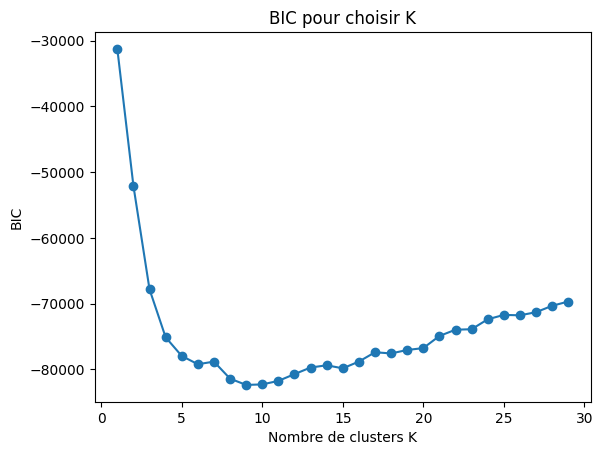

In [43]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

Z = np.load('Z.npy')  # Chargez votre Z

# Choisir K optimal (critère du coude sur BIC)
bics = []
ks = range(1, 30)
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(Z)
    bics.append(gmm.bic(Z))

plt.plot(ks, bics, marker='o')
plt.title('BIC pour choisir K')
plt.xlabel('Nombre de clusters K')
plt.ylabel('BIC')
plt.show()  


In [44]:

# Fit GMM avec K choisi
K = 9  # Ajustez basé sur plot
gmm = GaussianMixture(n_components=K, random_state=42)
gmm.fit(Z)

# Log-vraisemblance (total)
log_lik = gmm.score(Z) * Z.shape[0]
print(f"Log-vraisemblance : {log_lik:.2f}")

# Inférence
clusters = gmm.predict(Z)

# Probs soft
probs = gmm.predict_proba(Z)
print("Exemple de probs pour première station :", probs[0])

# Params estimés
print("Poids π :", gmm.weights_)
print("Moyennes μ (forme) :", gmm.means_.shape)  # (K, 17)

Log-vraisemblance : 46296.70
Exemple de probs pour première station : [5.17564343e-220 0.00000000e+000 5.81955543e-076 9.99699015e-001
 1.14026985e-006 2.99844564e-004 0.00000000e+000 5.83294487e-021
 0.00000000e+000]
Poids π : [0.0777785  0.21826402 0.14063671 0.11573805 0.07856829 0.10131855
 0.15221366 0.1001173  0.01536492]
Moyennes μ (forme) : (9, 17)


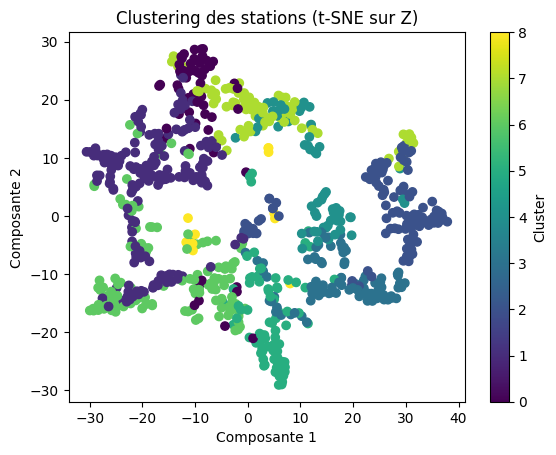

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
Z_2d = tsne.fit_transform(Z)

plt.scatter(Z_2d[:,0], Z_2d[:,1], c=clusters, cmap='viridis')
plt.title('Clustering des stations (t-SNE sur Z)')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar(label='Cluster')
plt.show()